<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning/blob/main/06_logistic_regression/1_logistic_regression_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

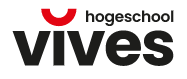<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# LOGISTIC REGRESSION: INTRO

Let's go back to the thermostat example we discussed in the introduction of this course. The data are stored in file `'thermostat.csv'`:

In [1]:
import pandas as pd

df = pd.read_csv('thermostat.csv')
df.head()

,temperature,heating
0,19.5,off
1,21.2,off
2,20.0,off
3,19.4,off
4,18.2,on


The example was used to explain the difference between traditional programming and machine learning. In machine learning, we don't know the rule that says when the heating is on or off for a given temperature. We only have some examples of temperature values and their corresponding heating label, and we have to derive a rule from these known examples. Once the rule is determined, we can apply it to a new temperature value and predict whether or not the heating is on.

As we already know, this is a **binary classification** problem because the target variable 'heating' is categorical with two possible labels only: 'on' or 'off'. There is one independent variable or feature: the 'temperature'.

In [4]:
X = df[['temperature']].values               # feature 'temperature' as 2D numpy array
y = (df.heating.values == 'on').astype(int)  # target 'heating' converted to array with zeros and ones

To solve the problem, we could determine a threshold that separates the temperatures values in the dataset and divides them into two classes. Intuitively, we may derive this threshold by taking the average of the highest 'on' temperature and the lowest 'off' temperature. However, there is an outlier, as is seen on the scatter plot:

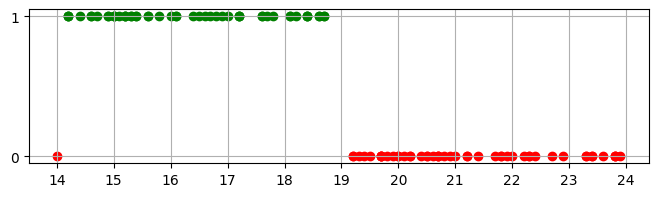

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def plot_thermostat(X, y):
    _, ax = plt.subplots(1, 1, figsize=(8, 2))
    ax.scatter(X.flatten()[y==1], y[y==1], color='green');
    ax.scatter(X.flatten()[y==0], y[y==0], color='red');
    ax.set_yticks((0, 1));
    ax.set_xticks(np.arange(14, 25));
    ax.grid();
    return ax

plot_thermostat(X, y);

Therefore, it is more effective to apply a more robust algorithm that considers all data points in deriving the threshold. In previous topic, we discussed **the perceptron algorithm**, which can be applied here:

In [9]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X / 25, y)    # normalize temperatures!
perceptron.score(X / 25, y)  # accuracy

0.99

The temperature values are normalized by dividing them by 25, which corresponds to the maximum temperature. The accuracy of the model is not 100% because of the outlier.

How do we calculate the threshold?

The perceptron model first applies a linear transformation to feature $X$:

> $f = aX+b$

To obtain label $y$, score $f$ is 'activated' using the heaviside step function $H$:

> $y = H(f)$

If $f$ is smaller than 0, then it is mapped to 0, otherwise it is mapped to 1.

So the threshold is found by solving $f=0$, which gives:

> $X_{threshold} = -b/a$

In [14]:
b, a = perceptron.intercept_.item(), perceptron.coef_.item()  # get b and a
threshold = (-b / a) * 25  # don't forget to 'denormalize'!
threshold

19.02587519025874

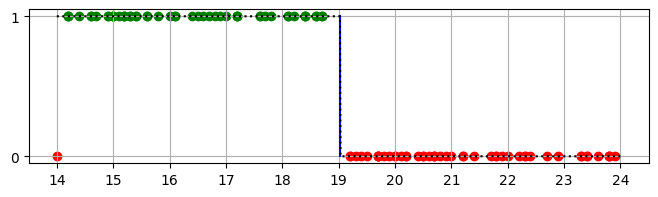

In [21]:
# scatter plot of the data
plot_thermostat(X, y);

# plot threshold
plt.plot(threshold * np.ones(2), [0, 1], 'b-');

# plot perceptron model
x = np.linspace(14, 24, 1000) / 25  # 1000 'normalized' points between 14 and 24
f = a * x + b                       # f score of x
H = lambda f: (f >= 0).astype(int)  # Heaviside function
plt.plot(x * 25, H(f), 'k:');       # don't forget to 'denormalize'!

**Logistic regression** is a *continuous perceptron* as it applies the **sigmoid function** instead of the step function to activate linear transformation $f$. The difference is that the sigmoid function maps $f$ to a value between 0 and 1, a percentage which may be interpreted as the probability that the label is 1. The mathematical definition of the sigmoid function, also called logistic function, is:

> $\sigma(f) = \dfrac{1}{1+e^{-f}}$

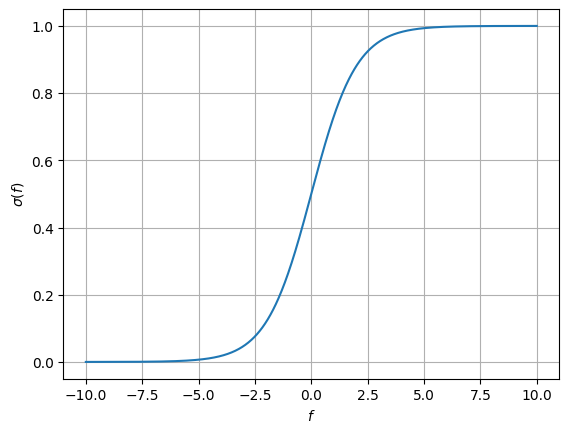

In [22]:
sigmoid = lambda f: 1 / (1 + np.exp(-f))

f = np.linspace(-10, 10, 1000)
plt.plot(f, sigmoid(f));
plt.grid();
plt.xlabel('$f$');
plt.ylabel('$\sigma(f)$');

We see that negative values of $f$ are mapped to a number less than 0.5, which means there is a higher probability the label is 0, whereas positive $f$ values are mapped to a number greater than 0.5, which means they are more likely to have label 1. When $f$ is zero, than the probability is 0.5, which means $f=0$ also defines the threshold in the logistic regression model.

Scikit-Learn has a class `LogisticRegression`, which is also part of the `linear_model` module:

In [23]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(penalty=None)  # no regularization
logistic_regression.fit(X / 25, y)    # normalize temperatures!
logistic_regression.score(X / 25, y)  # accuracy

0.99

We get the same accuracy. Let's check the threshold:

In [24]:
b, a = logistic_regression.intercept_.item(), logistic_regression.coef_.item()  # get b and a
threshold = (-b / a) * 25  # don't forget to 'denormalize'!
threshold

18.81247314969749

The threshold is a bit smaller here. Let's plot the result:

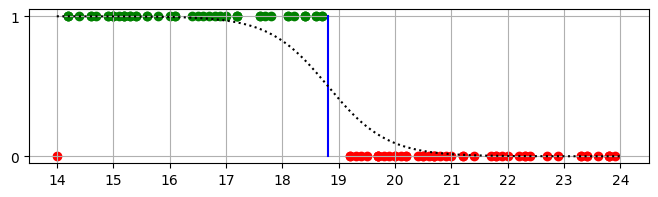

In [25]:
# scatter plot of the data
plot_thermostat(X, y);

# plot threshold
plt.plot(threshold * np.ones(2), [0, 1], 'b-');

# plot logistic regression model
x = np.linspace(14, 24, 1000) / 25   # 1000 'normalized' points between 14 and 24
f = a * x + b                        # f score of x
plt.plot(x * 25, sigmoid(f), 'k:');  # don't forget to 'denormalize'!

Applying the perceptron model, each temperature value is mapped to 0 or 1. The logistic regression model maps temperature values to probabilities between 0 and 1. So how do we get the exact labels? Well, by simply rounding the predicted probabilities $p$ :

> $p = \sigma(f)$

> $y = round(p)$

The probabilities $p$ are returned by method `predict_proba`. Suppose we have two new temperature values 17 and 20:

In [31]:
Xnew = np.array([[17], [20]])  # must be 2D!
logistic_regression.predict_proba(Xnew / 25)[:, 1]  # don't forget to 'normalize'!

array([0.96953522, 0.09388103])

When the temperature is 17 degrees, there is a probability of 97% that the heating is on, whereas there is only a probability of 9% that the heating is on when the temperature is 20 degrees. Method `predict` applies the `round` function to return these corresponding labels of 1 and 0:

In [32]:
logistic_regression.predict(Xnew / 25)  # don't forget to 'normalize'!

array([1, 0])

In this topic, we will discuss logistic regression in more detail. Instead of only 1 feature and 1 target, we will usually solve problems of 2 features and 1 target, in which case the threshold becomes a **separating straight line**. As is the case for the perceptron algorithm, logistic regression can also be applied to solve N-dimensional classification problems, in which case the model may be interpreted as a separating hyperplane.

---
---
**Sources**

*  Grokking Machine Learning (version 12), Manning Early Access Program, by Luis G. Serrano, 2020.
*  Sigmoid function on Wikipedia: https://en.wikipedia.org/wiki/Sigmoid_function
*  Online Scikit-Learn documentation: https://scikit-learn.org/stable/

---